In [90]:
"""
Module to calculate the fast fractional fourier transform.
Source: https://github.com/nanaln/python_frft/blob/master/frft/frft.py.
"""

import numpy as np
import scipy.signal
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt


def frft(f, a):
    """
    Calculate the fast fractional fourier transform.
    Parameters
    ----------
    f : numpy array
        The signal to be transformed.
    a : float
        fractional power
    Returns
    -------
    data : numpy array
        The transformed signal.
    References
    ---------
     .. [1] This algorithm implements `frft.m` from
        https://nalag.cs.kuleuven.be/research/software/FRFT/
    """
    ret = np.zeros_like(f, dtype=np.complex)
    f = f.copy().astype(np.complex)
    N = len(f)
    shft = np.fmod(np.arange(N) + np.fix(N / 2), N).astype(int)
    sN = np.sqrt(N)
    a = np.remainder(a, 4.0)

    # Special cases
    if a == 0.0:
        return f
    if a == 2.0:
        return np.flipud(f)
    if a == 1.0:
        ret[shft] = np.fft.fft(f[shft]) / sN
        return ret
    if a == 3.0:
        ret[shft] = np.fft.ifft(f[shft]) * sN
        return ret

    # reduce to interval 0.5 < a < 1.5
    if a > 2.0:
        a = a - 2.0
        f = np.flipud(f)
    if a > 1.5:
        a = a - 1
        f[shft] = np.fft.fft(f[shft]) / sN
    if a < 0.5:
        a = a + 1
        f[shft] = np.fft.ifft(f[shft]) * sN

    # the general case for 0.5 < a < 1.5
    alpha = a * np.pi / 2
    tana2 = np.tan(alpha / 2)
    sina = np.sin(alpha)
    f = np.hstack((np.zeros(N - 1), _sincinterp(f), np.zeros(N - 1))).T

    # chirp premultiplication
    chrp = np.exp(-1j * np.pi / N * tana2 / 4 *
                     np.arange(-2 * N + 2, 2 * N - 1).T ** 2)
    f = chrp * f

    # chirp convolution
    c = np.pi / N / sina / 4
    ret = scipy.signal.fftconvolve(
        np.exp(1j * c * np.arange(-(4 * N - 4), 4 * N - 3).T ** 2),
        f
    )
    ret = ret[4 * N - 4:8 * N - 7] * np.sqrt(c / np.pi)

    # chirp post multiplication
    ret = chrp * ret

    # normalizing constant
    ret = np.exp(-1j * (1 - a) * np.pi / 4) * ret[N - 1:-N + 1:2]

    return ret


def ifrft(f, a):
    """
    Calculate the inverse fast fractional fourier transform.
    Parameters
    ----------
    f : numpy array
        The signal to be transformed.
    a : float
        fractional power
    Returns
    -------
    data : numpy array
        The transformed signal.
    """
    return frft(f, -a)


def _sincinterp(x):
    N = len(x)
    y = np.zeros(2 * N - 1, dtype=x.dtype)
    y[:2 * N:2] = x
    xint = scipy.signal.fftconvolve(
        y[:2 * N],
        np.sinc(np.arange(-(2 * N - 3), (2 * N - 2)).T / 2),
    )
    return xint[2 * N - 3: -2 * N + 3]

def _peak_height(a):
    return -np.max(np.abs(frft(signal,a)))

def optimise_a(signal):
    """
    Parameters
    ----------
    signal: numpy array
        A numpy array to transform (normally a chirp).
    
    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a ``OptimizeResult`` object.
        Important attributes are: ``x`` the solution array, ``success`` a
        Boolean flag indicating if the optimizer exited successfully and
        ``message`` which describes the cause of the termination. See
        `OptimizeResult` for a description of other attributes.
    """
    return minimize_scalar(peak_height, bounds=[0.0,2.0], method='bounded', options={'maxiter':30})

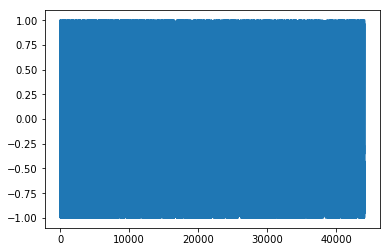

In [69]:
fs = 44100

t_chirp = np.linspace(0,1,fs)
chirp_standard = scipy.signal.chirp(t_chirp, 1e3, 1, 10e3, method='linear')

plt.plot(chirp_standard)

0.8717241379310344


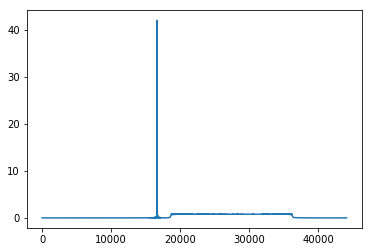

In [70]:
y_max = []
signal = chirp_standard

a_vals = np.linspace(0.86,0.88, 30)

for a in a_vals:
    y_max.append(np.max(frft(signal,a)))

a = a_vals[np.argmax(np.array(y_max))]
y = np.abs(frft(signal, a))

print(a)
plt.plot(y)

In [78]:
def peak_height(a):
    return -np.max(np.abs(frft(signal,a)))

In [79]:
from scipy.optimize import minimize_scalar

In [86]:
res = minimize_scalar(peak_height, bounds=[0.0,2.0], method='bounded', options={'maxiter':30})

In [89]:
res

     fun: -72.79829573355825
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 0.8718468064328603

In [85]:
help(minimize_scalar)

Help on function minimize_scalar in module scipy.optimize._minimize:

minimize_scalar(fun, bracket=None, bounds=None, args=(), method='brent', tol=None, options=None)
    Minimization of scalar function of one variable.
    
    Parameters
    ----------
    fun : callable
        Objective function.
        Scalar function, must return a scalar.
    bracket : sequence, optional
        For methods 'brent' and 'golden', `bracket` defines the bracketing
        interval and can either have three items ``(a, b, c)`` so that
        ``a < b < c`` and ``fun(b) < fun(a), fun(c)`` or two items ``a`` and
        ``c`` which are assumed to be a starting interval for a downhill
        bracket search (see `bracket`); it doesn't always mean that the
        obtained solution will satisfy ``a <= x <= c``.
    bounds : sequence, optional
        For method 'bounded', `bounds` is mandatory and must have two items
        corresponding to the optimization bounds.
    args : tuple, optional
        E

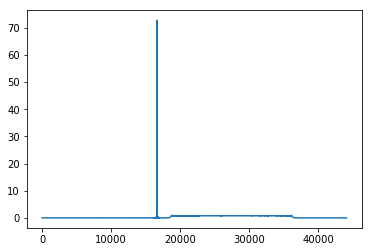

In [83]:
plt.plot(np.abs(frft(chirp_standard, 0.8718463982292025)))